In [1]:
# install required libraries and packages
!pip install -qr requirements.txt


[notice] A new release of pip available: 22.2.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# common
import os
import random
import numpy as np

# viz
from IPython.display import display

# local
from ig_enabler import (
    ig,
    visualize
)

# third party 
from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer
)
from datasets import load_dataset

## Objective

Determine which words in an input sentence contribute the most to a LLM sentiment classification prediction using Integrated Gradients.

## Load dataset and sample

In [3]:
def get_rand_sample(dataset):
    sample_idx = random.randint(0, len(dataset))
    sample = dataset.select([sample_idx])
    review = sample['text'][0]
    label = sample['label'][0]
    return review, label

In [4]:
dataset = load_dataset('imdb')
review, label = get_rand_sample(dataset['train'])
print(f'Review: {review}\nLabel: {label}')

Review: Wow. What a wonderful film. The script is nearly perfect it appears this is the only film written by Minglun Wei,I hope he has more stories in him.<br /><br />The acting is sublime. Renying Zhou as Doggie was amazing -- very natural talent, and Xu Zhu was a delight - very believable as the jaded old traditionalist. <br /><br />The soundtrack was very effective, guiding without being overwhelming. <br /><br />If only more movies like this were made whether in Hollywood or Hong Kong- a family friendly, well acted, well written, well directed, near perfect gem.
Label: 1


## Load finetuned model and tokenizer

In [6]:
tokenizer = AutoTokenizer.from_pretrained("lvwerra/distilbert-imdb")
model = AutoModelForSequenceClassification.from_pretrained("lvwerra/distilbert-imdb")

In [5]:
def sigmoid(logits):
    return 1.0 / (1.0 + np.exp(-logits))

In [7]:
model_inputs = tokenizer(review, return_tensors="pt", truncation=True)
model_outputs = model(**model_inputs)

# extract logits
logits = model_outputs["logits"][0]
logits = logits.detach().numpy()
output = sigmoid(logits)
pred, prob = np.argmax(output), max(output)

label = "POSITIVE" if pred==1 else "NEGATIVE"
print(f"label: {label}, prob: {prob}")

label: POSITIVE, prob: 0.9452095627784729


## Integrated gradients

Allows us to examine how much each input feature contributes to a LLMS's output by assigning importance scores to each input feature. 

1. Start with a baseline or a "neutral" input
2. Define a certain number of steps that we need to take in order to get from baseline to the actual input of the model
3. In each step, we have the model output a prediction
4. Take the gradient of the prediction w.r.t the input
5. Accumlate the gradients and take the integral w.r.t the output

In [8]:
ig_enabled_model = ig.IGWrapper(model)

scores = ig_enabled_model(model_inputs['input_ids'],
                          model_inputs['attention_mask'],
                          baseline=None, 
                          num_steps=5)

scores = scores.tolist()[0]

step: 0/5
input embedding: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
step: 1/5
input embedding: tensor([[[ 0.0082, -0.0025, -0.0044,  ...,  0.0126,  0.0043,  0.0051],
         [-0.0042, -0.0035, -0.0221,  ..., -0.0016,  0.0020, -0.0112],
         [-0.0044, -0.0027, -0.0014,  ...,  0.0016,  0.0006, -0.0005],
         ...,
         [-0.0032, -0.0146, -0.0074,  ..., -0.0235, -0.0099, -0.0182],
         [-0.0044, -0.0027, -0.0014,  ...,  0.0016,  0.0006, -0.0005],
         [-0.0034, -0.0021, -0.0024,  ..., -0.0045,  0.0011, -0.0015]]])
step: 2/5
input embedding: tensor([[[ 0.0165, -0.0050, -0.0088,  ...,  0.0251,  0.0085,  0.0101],
         [-0.0084, -0.0071, -0.0442,  ..., -0.0033,  0.0040, -0.0225],
         [-0.0087, -0.0055, -0.0029,  ...,  0.0031,  0.0012, -0.0009],
  

## Visualize top tokens

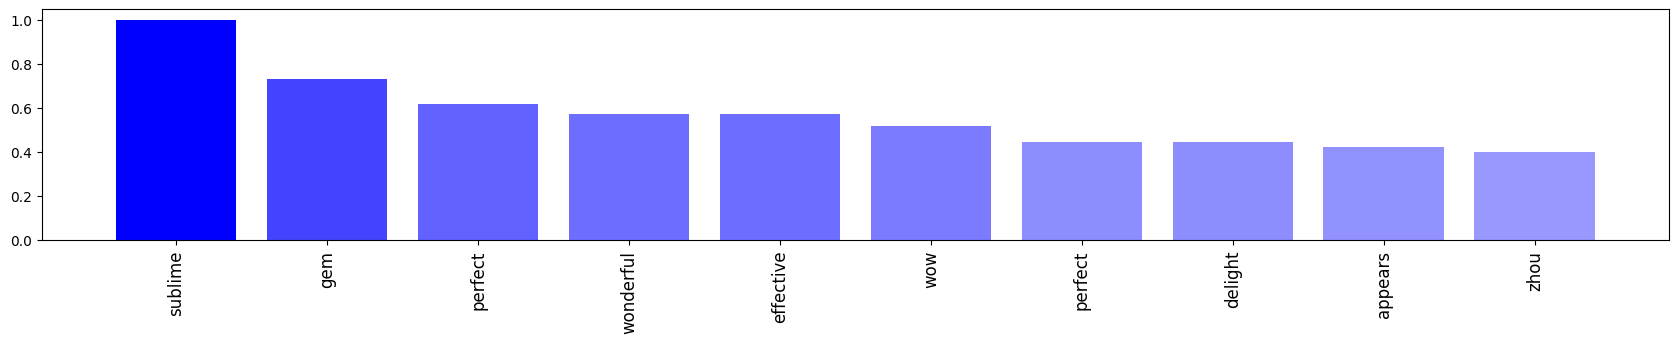

In [9]:
tokens = tokenizer.convert_ids_to_tokens(model_inputs['input_ids'][0])

display(visualize.visualize_token_scores(tokens, scores))

visualize.plot_topk_scores(tokens, scores, 10)